### Generating confusion matrices for the best performing classifier per syndrome

In [1]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
import itertools
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import date
from os.path import join, isfile
from os import listdir
import time
import seaborn as sns

In [2]:
def read_rep(syn_name, syn_csv, ID_csv, data_dir):
    
    # open directories
    syn_dir = data_dir+"\\{}-patients".format(syn_name)
    ID_dir = data_dir+ "\\{}-selected-ID-controls".format(syn_name)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and (".jpg" in f or ".JPG" in f) ]
    
    data = []
    labels = []

    for i, csv_file in enumerate([ID_csv, syn_csv]):
        with open (csv_file, newline='') as file:
            reader = csv.reader(file, delimiter=',')
            for row in reader:
                if row[0] in files_syn or row[0] in files_ID:
                    rep = list(map(float, row[1:]))
                    data.append(rep)
                    labels.append(i)

    return np.array(data), np.array(labels)

In [3]:
def read_rep2(syn_name, syn_csv, ID_csv, data_dir):
    
    # open directories
    syn_dir = data_dir+"\\{}-patients".format(syn_name)
    ID_dir = data_dir+ "\\{}-selected-ID-controls".format(syn_name)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and (".jpg" in f or ".JPG" in f) ]
    
    data = []
    labels = []

    for i, csv_file in enumerate([ID_csv, syn_csv]):
        with open (csv_file, newline='') as file:
            reader = csv.reader(file, delimiter=',')
            for row in reader:
                if row[0] in files_syn or row[0] + ".jpg" in files_ID or row[0] + ".JPG" in files_ID:
                    rep = list(map(float, row[1:]))
                    data.append(row)
                    labels.append(i)
    
    return np.array(data), np.array(labels)

In [4]:
def read_rep_fr(kdv_csv, ID_csv, low_age, high_age, data_dir):
    
    # open directories
    kdv_dir = data_dir+"\\kdv-patients-age-group-"+str(low_age) + "-" + str(high_age)
    ID_dir = data_dir+ "\\kdv-selected-ID-controls-age-group-"+str(low_age) + "-" + str(high_age)

    # get list of filenames
    files_kdv = [f for f in listdir(kdv_dir) if (isfile(join(kdv_dir, f)) & ("crop" not in f))]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f)) & ("crop" not in f))]
    
    data = []
    labels = []

    for i, csv_file in enumerate([ID_csv, kdv_csv]):
        with open (csv_file, newline='') as file:
            reader = csv.reader(file, delimiter=',')
            for row in reader:
                if row[0] in files_kdv or row[0] in files_ID:
                    rep = list(map(float, row[1:]))
                    data.append(rep)
                    labels.append(i)
    
    return np.array(data), np.array(labels)

In [5]:
def plot_pca_tsne(data, labels, lowest_age = -1, highest_age = -1):
    plt.figure(figsize=(12,6))
    plt.plot([1,2])

    # visualize data in tnse (men/women)
    X_embedded_tsne = TSNE(n_components=2, init='pca').fit_transform(data)

    plt.subplot(121)
    unique = list(set(labels))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    for i, u in enumerate(unique):
        xi = [X_embedded_tsne[j, 0] for j  in range(len(X_embedded_tsne[:,0])) if labels[j] == u]
        yi = [X_embedded_tsne[j, 1] for j  in range(len(X_embedded_tsne[:,1])) if labels[j] == u]
        plt.scatter(xi, yi, c=[colors[i]], label=str(u))
    plt.legend()
    plt.title("t-sne for age range {}-{}".format(lowest_age, highest_age))

    # visualize data in pca (men/women)
    X_embedded_pca = PCA(n_components=2).fit_transform(data)

    plt.subplot(122)
    unique = list(set(labels))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    for i, u in enumerate(unique):
        xi = [X_embedded_pca[j, 0] for j  in range(len(X_embedded_pca[:,0])) if labels[j] == u]
        yi = [X_embedded_pca[j, 1] for j  in range(len(X_embedded_pca[:,1])) if labels[j] == u]
        plt.scatter(xi, yi, c=[colors[i]], label=str(u))
    plt.legend()
    plt.title("pca for age range{}-{}".format(lowest_age, highest_age))

    plt.show()

In [6]:
def plot_roc_curve(y_true, y_pred): 
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(1, figsize=(12,6))
    roc_auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label='LOOCV ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [7]:
def normalize(data, i):

    if i == 0:
        return data
    
    if i == 1:
        return Normalizer().fit_transform(data)
        
    if i == 2:
        return StandardScaler().fit_transform(data)

### Method 1: k-NN

In [8]:
def knn_classifier_conf_matrix(data, labels, k, norm):

    data = normalize(data, norm) 
    all_y, all_probs, all_preds = [], [], [] 
    
    loo = LeaveOneOut()

    # leave one out split and make prediction
    for train, test in loo.split(data):
        all_y.append(labels[test])
        model = KNeighborsClassifier(n_neighbors=k, weights='distance')
        model = model.fit(data[train], labels[train])                
        all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
        all_preds.append(model.predict(data[test].reshape(1, -1)))

    # based on all predictions make aroc curve and confusion matrix
    aroc = roc_auc_score(all_y, all_probs)
    tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
                
    return tn, fp, fn, tp, aroc

### Method 2: SVM

In [9]:
def svm_classifier_conf_matrix(data, labels, kernel, norm):

    data = normalize(data, norm) 
    all_y, all_probs, all_preds = [], [], [] 

    loo = LeaveOneOut()

    # leave one out split and make prediction
    for train, test in loo.split(data):
        all_y.append(labels[test])
        model = SVC(kernel=kernel, probability=True)
        model = model.fit(data[train], labels[train])
        all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
        all_preds.append(model.predict(data[test].reshape(1, -1)))

    # based on all predictions make aroc curve and confusion matrix
    aroc = roc_auc_score(all_y, all_probs)
    tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()

    return tn, fp, fn, tp, aroc


### Method 3: Random Forest

In [10]:
def rf_classifier_conf_matrix(data, labels, trees, norm):
            
    data = normalize(data, norm) 
    all_y, all_probs, all_preds = [], [], [] 
    
    loo = LeaveOneOut()

    # leave one out split and make prediction
    for train, test in loo.split(data):
        all_y.append(labels[test])
        model = RandomForestClassifier(n_estimators=trees)
        model = model.fit(data[train], labels[train])
        all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
        all_preds.append(model.predict(data[test].reshape(1, -1)))

    # based on all predictions make aroc curve and confusion matrix
    aroc = roc_auc_score(all_y, all_probs)
    tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()

    return tn, fp, fn, tp, aroc

### Method 4: Gradient Boosting classifier

In [11]:
def gr_classifier_conf_matrix(data, labels, trees, norm):

    data = normalize(data, norm) 
    all_y, all_probs, all_preds = [], [], [] 

    loo = LeaveOneOut()

    # leave one out split and make prediction
    for train, test in loo.split(data):
        all_y.append(labels[test])
        model = GradientBoostingClassifier(n_estimators=trees)
        model = model.fit(data[train], labels[train])
        all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
        all_preds.append(model.predict(data[test].reshape(1, -1)))

    # based on all predictions make aroc curve and confusion matrix
    aroc = roc_auc_score(all_y, all_probs)
    tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()

    return tn, fp, fn, tp, aroc


### Method 5: AdaBoost

In [12]:
def ada_classifier_conf_matrix(data, labels, trees, norm):

    data = normalize(data, norm) 
    all_y, all_probs, all_preds = [], [], [] 

    loo = LeaveOneOut()

    # leave one out split and make prediction
    for train, test in loo.split(data):
        all_y.append(labels[test])
        model = AdaBoostClassifier(n_estimators=trees)
        model = model.fit(data[train], labels[train])
        all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
        all_preds.append(model.predict(data[test].reshape(1, -1)))

    # based on all predictions make aroc curve and confusion matrix
    aroc = roc_auc_score(all_y, all_probs)
    tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
               
    return tn, fp, fn, tp, aroc


In [13]:
def concatenate(syn_name, data_dir, data_combination, nr_feats): 

    method = "deepface"
    syn_csv = data_dir+"\\representations\{}-patients-{}.csv".format(syn_name, method)
    ID_csv  = data_dir+"\\representations\ID-controls-{}.csv".format(method)
    data_df, labels_df = read_rep(syn_name, syn_csv, ID_csv, data_dir)
    
    method = "dlib"
    syn_csv = data_dir+"\\representations\{}-patients-{}.csv".format(syn_name, method)
    ID_csv  = data_dir+"\\representations\ID-controls-{}.csv".format(method)
    data_dlib, labels_dlib = read_rep(syn_name, syn_csv, ID_csv, data_dir)

    
    if data_combination == 0: # or data_combination == 2 or data_combination == 3:
        # only deepface
        data = data_df
        labels = labels_df
    
    if data_combination == 1: # or data_combination == 2:
        # only dlib
        data, labels  = [], []
        for index, dlib_i in enumerate(data_dlib):
            if not all(v == 0 for v in dlib_i):
                #only if a face is found
                data.append(dlib_i) # concatenation of 4096 deepface + 2210 dlib
                labels.append(labels_dlib[index])
                
                
    if data_combination == 2 or data_combination == 3 or data_combination == 4:# or data_combination == 3 or data_combination == 4:
        # deepface + dlib (all features) 
        data, labels  = [], []
        for index, (df_i, dlib_i) in enumerate(zip(data_df, data_dlib)):
            if not all(v == 0 for v in dlib_i):
                #only if a face is found 
                if not isinstance(df_i, list):
                    df_i = df_i.tolist()
                if not isinstance(dlib_i, list):
                    dlib_i = dlib_i.tolist()  
                    
                data.append(df_i+dlib_i) # concatenation of 4096 deepface + 2210 dlib
                labels.append(labels_df[index])
                
                                               
    if data_combination == 3:
        # deepface + dlib (x most important features)
        # data, labels are already filled from the above if statement
                                               
        # using a Random Forest the x most important features are used                                   
        forest = RandomForestClassifier(n_estimators=10,random_state=0) # 10 has been found with best aroc scores
        forest.fit(data, labels)
        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
        indices = np.argsort(importances)[::-1]
        indices = indices[0:nr_feats] 

        data2 = []
        for row in data:
            data2.append(np.array(row)[indices])                                
        data = data2

                                               
    nr_comps = 0
    if data_combination == 4:
        # pca components that explain > 0.9 variance
        for i in range(0, np.array(data).shape[0]):
            pca = PCA(n_components=i)
            components = pca.fit_transform(data)    
            if sum(pca.explained_variance_ratio_) > 0.9:
                nr_comps = i
        
        pca = PCA(n_components=nr_comps)
        data = pca.fit_transform(data)       
        
    
    if data_combination == 5 or data_combination == 7:
        # openface 
        method = "openface"
        syn_csv = data_dir+"\\representations\{}-patients-{}.csv".format(syn_name, method)
        ID_csv  = data_dir+"\\representations\ID-controls-{}.csv".format(method)
        data_openface, labels_openface = read_rep2(syn_name, syn_csv, ID_csv, data_dir)
        
        data = []
        openface_names = data_openface[:,0]
        data_openface = np.array(data_openface)[:, 1:]
        for openface_i in data_openface:
            rep = [float(i) for i in openface_i.tolist()]
            data.append(rep)

        labels = np.array(labels_openface)
        
        
    if data_combination == 6 or data_combination == 7:
        # cfps        
        method = "cfps"
        syn_csv = data_dir+"\\representations\{}-patients-{}.csv".format(syn_name, method)
        ID_csv  = data_dir+"\\representations\ID-controls-{}.csv".format(method)
        data_cfps, labels_cfps = read_rep2(syn_name, syn_csv, ID_csv, data_dir)
        
        data = []
        cfps_names = data_cfps[:,0]
        data_cfps = np.array(data_cfps)[:, 1:]
        
        for cfps_i in data_cfps:
            rep = [float(i) for i in cfps_i.tolist()]
            data.append(rep)
            
        labels = np.array(labels_cfps)

        
    if data_combination == 7:
        # openface + cfps 
           
        matches = [i==j for i, j in zip(openface_names, cfps_names)]
        
        data, labels  = [], []
        for index, (openface_i, cfps_i) in enumerate(zip(data_openface, data_cfps)):
            if(matches[index]):
                if not isinstance(openface_i, list):
                    openface_i = openface_i.tolist()
                if not isinstance(cfps_i, list):
                    cfps_i = cfps_i.tolist()  
                    
                rep_list = openface_i+cfps_i
                rep = [float(i) for i in rep_list]
                data.append(rep) # concatenation of 128 openface + 340 cfps
                labels.append(labels_openface[index].astype(np.float64))
     
            
            #### nog aanpassen deze 
    if data_combination == 8:
        # facereader
        method = "facereader"
        kdv_csv = data_dir+"\\representations\kdv-patients-"+method+".csv"  
        ID_csv  = data_dir+"\\representations\ID-controls-"+method+".csv"

        data_fr, labels_fr = read_rep_fr(kdv_csv, ID_csv, low_age, high_age, data_dir)      
        
        data, labels  = [], []
        for index, fr_i in enumerate(data_fr):
            if not all(v == 0 for v in fr_i):
                data.append(fr_i)
                labels.append(labels_fr[index])
    
    return 0, np.array(data), np.array(labels)
    

In [14]:
def plot_conf_matrix(tn, fp, fn, tp, aroc, syn_name, classifier, norm):
    
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn)
   
    
    conf_matrix = [[tp, fp],
             [fn, tn]]
    df_cm = pd.DataFrame(conf_matrix, index = ["{}_pred".format(syn_name), "Control_pred"],
                      columns = [syn_name, "Control"])
    plt.figure(figsize = (8, 6))
    sns_heat = sns.heatmap(df_cm, annot=True)
    plt.title(" {} with  {} and normalization: {}\n aroc: {:.3f}, spec: {:.3f}, sens: {:.3f}".format(syn_name, classifier, norm, aroc, spec, sens))
    
    plt.savefig("results/{}/{}_conf_matrix.jpg".format(syn_name, syn_name))
    plt.show()


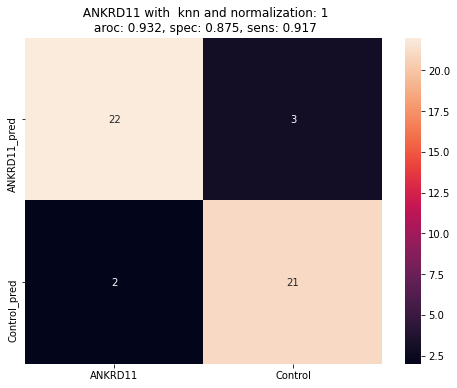

done running main file


In [15]:

def main():    

    syn_list = ['ADNP','ANKRD11', 'CDK13', 'DEAF1', 'DYRK1A', 'EHMT1', 'FBXO11', 'SON', 'SPOP', 'WAC', 'YY1']
    
    # syndrome
    syn_name = syn_list[1]
    
    # data combination
    data_combination = 2
    
    # classifier
    classifier =  "knn"
    
    # parameters
    params = [3]
    
    # normalization
    norm = 1
    
    
    ###################### UNMUTABLE CODE #######################
    
    data_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}".format(syn_name) 
    nr_comps, data, labels = concatenate(syn_name, data_dir, data_combination, 300) 
    
    
    if classifier == "knn":
        tn, fp, fn, tp, aroc  = knn_classifier_conf_matrix(data, labels, params[0], norm)
        plot_conf_matrix(tn, fp, fn, tp, aroc, syn_name, classifier, norm)
        
    if classifier == "svm":
        tn, fp, fn, tp, aroc  = svm_classifier_conf_matrix(data, labels, params[0], norm)
        plot_conf_matrix(tn, fp, fn, tp, aroc, syn_name, classifier, norm)
        
    if classifier == "random_forest":
        tn, fp, fn, tp, aroc  = rf_classifier_conf_matrix(data, labels, params[0], norm)
        plot_conf_matrix(tn, fp, fn, tp, aroc, syn_name, classifier, norm)               
                
    if classifier == "gradient_boost":
        tn, fp, fn, tp, aroc  = gr_classifier_conf_matrix(data, labels, params[0], norm)
        plot_conf_matrix(tn, fp, fn, tp, aroc, syn_name, classifier, norm)                        
                        
    if classifier == "ada_boost":
        tn, fp, fn, tp, aroc  = ada_classifier_conf_matrix(data, labels, params[0], norm)
        plot_conf_matrix(tn, fp, fn, tp, aroc, syn_name, classifier, norm)        

        
    print("done running main file")
    
main()
    